# <center>Read Keystroke Data and Build Model to Process</center>

In [1]:
import os
import copy
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm
import sklearn.cross_validation

input_path = "Dataset/Kevin and Maxion/DSL-StrongPasswordData.csv"
print input_path;

Dataset/Kevin and Maxion/DSL-StrongPasswordData.csv


## Import Raw Data and Extract Features. Pre-process the data 

### Dataset (The CMU keystroke dynamics dataset)

* The CMU benchmark dataset contains keystroke dynamics consisting of the dwell time for each key and the latencies between two successive keys for static password string “.tie5Roanl”.
* For each subject, there were data collection sessions with at least one day apart between two sessions. 50 repeated keystroke strings were collected in each session, resulting in a total 400 sample for each subject.
* For each typed 10-letter password and the final enter key, the dwell time and diagraphs give rise to a 31 dimensional feature vector.

Although the keystroke features provide sufficiently distinguishing patterns for each subject, they are highly correlated, with large scale variations, and typical of noise and outliers. Someone has previously proposed a new distance metric to effectively handle these challenges that are intrinsic to keystroke dynamics data.

In [2]:
file = open(input_path, "r");

raw_data = file.read();
print type(raw_data);

data_lines = np.array(raw_data.splitlines());
print data_lines[0];

data = np.array([ x.split(",") for x in data_lines]);
data = np.delete(data, 0, 0);

# change username to index (0-50)
for i in range(len(data)):
    data[i][0] = i/400;

data = data.astype(np.float);
data_two = data[0:2*400];
data_user = np.array([data[i*400:(i+1)*400] for i in range(51)]);

print data.shape;
# print data;
print data_user.shape;
# print data_user;

<type 'str'>
subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,H.e,DD.e.five,UD.e.five,H.five,DD.five.Shift.r,UD.five.Shift.r,H.Shift.r,DD.Shift.r.o,UD.Shift.r.o,H.o,DD.o.a,UD.o.a,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
(20400L, 34L)
(51L, 400L, 34L)


### Build train dataset and test dataset

In [5]:
# split data to train_data and test_data for cross validation

def pre_process(data, fold, shuffle):
    kf = sklearn.cross_validation.KFold(len(data), n_folds=fold, shuffle=shuffle);
    print kf;
    for train_index, test_index in kf:
        train, test = data[train_index], data[test_index];
        
    train_targets = train[:, 0:1].ravel();
    train_features = train[:, 3:];
    test_targets = test[:, 0:1].ravel();
    test_features = test[:, 3:];
    
    return train_targets, train_features, test_targets, test_features;
    

In [6]:

train_target, train_feature, test_target, test_feature = pre_process(data, 5, True);
train_target_two, train_feature_two, test_target_two, test_feature_two = pre_process(data_two, 5, True);

subjects = np.unique(train_target);
subjects_two = subjects[0:2];
n_classes = len(subjects);
n_classes_two = len(subjects_two);
print subjects;
print n_classes;

sklearn.cross_validation.KFold(n=20400, n_folds=5, shuffle=True, random_state=None)
sklearn.cross_validation.KFold(n=800, n_folds=5, shuffle=True, random_state=None)
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.]
51


### Train the SVM model to analyze data

When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 
* The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly.
* gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
* Proper choice of C and gamma is critical to the SVM’s performance. One is advised to use sklearn.grid_search.GridSearchCV with C and gamma spaced exponentially far apart to choose good values.

In [5]:
clf = svm.SVC(gamma=1, C=300.);
clf2 = svm.SVC(gamma=1, C=300., decision_function_shape='ovo');
## for now, gamma = 1, C = 300 is my best combination of those two parameters in this model

#clf.fit(train_data, train_target);
clf2.fit(train_feature_two, train_target_two);
# libsvm = svm.libsvm.fit(x, y);

#print (clf, "\n", clf2);
print (clf2.score(test_feature_two, test_target_two));
print (sklearn.cross_validation.cross_val_score(clf, train_feature_two, train_target_two, cv=5));

# for i in range(20):
#     print (clf.predict(test_data[i]), test_target[i]);

    

0.98125
[ 0.79069767  0.93023256  0.9765625   0.99212598  0.88188976]


### Use Neutral Network to analyze 
* In scikit-learn, the neural network model is Restricted Boltzmann machines (RBM). The features extracted by an RBM or a hierarchy of RBMs often give good results when fed into a linear classifier such as a linear SVM or a perceptron. 

* A Restricted Boltzmann Machine with binary visible units and binary hiddens. Parameters are estimated using Stochastic Maximum Likelihood (SML), also known as Persistent Contrastive Divergence (PCD)

* Two simple and easy search strategies for tuning parameter: Grid Search; Random Search

In [ ]:
# from sklearn.neural_network import BernoulliRBM
# from sklearn.cross_validation import train_test_split

# a = np.array([train_data[train_target == user] for user in subjects]);
# print a[0:5];
# print len(a[0]);


d = np.array([1, 2, 3, 4, 5]);
b = np.array(['1', '1', '2', '2', '4']);
c = np.array(['1', '2', '3', '4', '5']);
print np.array([d[b == x].mean() for x in c]);

### Gaussian Mixture Models with Universal Background Model
* A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions wih unknown parameters. (Gaussian Distribution = Normal Distribution)
* The GMM object implements the EM algorithm for fitting mixture-of-Gaussian models. 
* GMM.fit method learns a Gaussian Mixture Model from train data. Gmm.predict method can assign each sample of test data to the Gaussian class which it mostly probably belong to.
* The GMM has different options to constrain the covariance: spherical, diagonal, tied or full covariance. Since we have class labels for the training data, we can initialize the GMM parameters in a supervised manner.

In [5]:
## Draw the ellipses of the clusters
def make_ellipses(gmm, ax):
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        

* Existing works in applying GMM to keystroke authentication is to train a GMM for each genuine user. At testing time, a keystroke feature is evaluated against the genuine user's GMM and a threshold is applied to the likelihood of the feature vector to make the decision.

* The idea of TMM-UBM is to train another GMM from a large pool of so-called background subjects (except the genuine user and the actual testing subjects). When the pool of background subjects is large enough, the UBM will have a good chance to reasonably represent any imposter's data. Thus, the imposter can have a relatively high likelihood score under UBM.

* A key common feature of these algorithms is that an unsupervised training is conducted on a large pool of subjects at the first stage to allow the classifier take advantage of the overall data distribution in the feature space for improved performance.

('spherical', GMM(covariance_type='spherical', init_params='wc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=20, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0))
('Train_accuracy', 60.0)
('Test_accuracy', 66.25)
(42L, 31L)
(118L, 31L)
('diag', GMM(covariance_type='diag', init_params='wc', min_covar=0.001, n_components=2,
  n_init=1, n_iter=20, params='wmc', random_state=None, thresh=None,
  tol=0.001, verbose=0))
('Train_accuracy', 54.0625)
('Test_accuracy', 58.125000000000007)
(43L, 31L)
(117L, 31L)
('full', GMM(covariance_type='full', init_params='wc', min_covar=0.001, n_components=2,
  n_init=1, n_iter=20, params='wmc', random_state=None, thresh=None,
  tol=0.001, verbose=0))
('Train_accuracy', 56.875)
('Test_accuracy', 53.125)
(131L, 31L)
(29L, 31L)
('tied', GMM(covariance_type='tied', init_params='wc', min_covar=0.001, n_components=2,
  n_init=1, n_iter=20, params='wmc', random_state=None, thresh=None,
  tol=0.001, verbose=0))
('Train_accuracy', 90.31

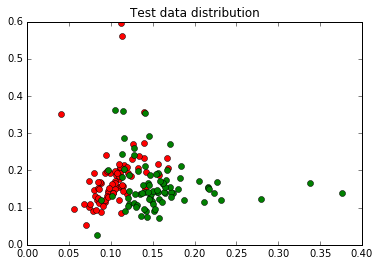

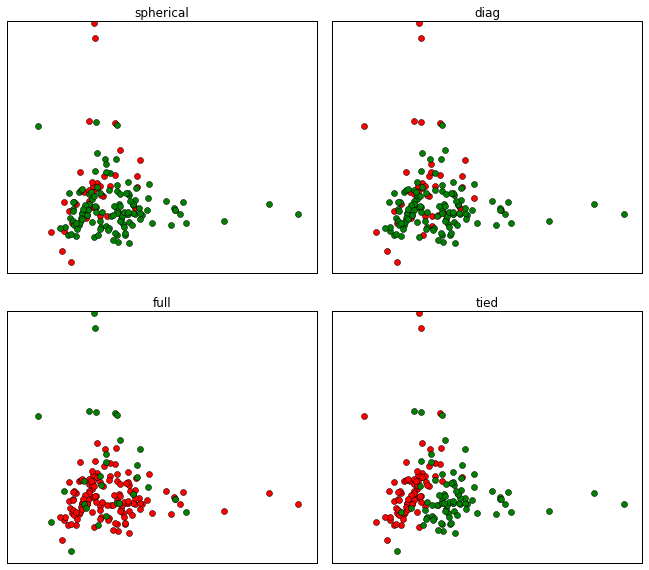

In [7]:
from sklearn.mixture import GMM
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold

#Try GMMs with different types of covariances
# How to find the best n_components
classifiers = dict((covar_type, GMM(n_components=2, covariance_type=covar_type, init_params='wc', n_iter=20)) 
                   for covar_type in ['spherical', 'diag', 'tied', 'full']);

n_classifiers = len(classifiers);

plt.figure(figsize = (6, 4));
for n, color in enumerate('rg'):
    visual = test_feature_two[test_target_two == n];
    plt.plot(visual[:, 0], visual[:, 1], 'o', color=color);
    
plt.title("Test data distribution");


plt.figure(figsize=(3 * n_classifiers * 0.75, 8));
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05, left=.01, right=.99);

for index, (name, clf) in enumerate(classifiers.items()):
    # Since we have class labels for the training data, 
    # we can initialize the GMM parameters in a supervised manner.
    print (name, clf);
    
    clf.means_ = np.array([train_feature_two[train_target_two == user].mean(axis=0) for user in subjects_two]);

    # means_ : array, shape (n_components, n_features) Mean parameters for each mixture component.
    # axis : Axis or axes along which the means are computed. The default is to compute the mean of the flattened array. 
    # If this is a tuple of ints, a mean is performed over multiple axes, instead of a single axis or all the axes as before.
    # Compute the mean of features of every user seperately
    
    # Train the other parameters using the EM algorithm
    clf.fit(train_feature_two);
    
    plt.subplot(2, n_classifiers/2, index+1); #subplot(nrows, ncols, plot_number)
    
    train_pred = clf.predict(train_feature_two);
    test_pred = clf.predict(test_feature_two);
    train_accuracy = np.mean(train_pred == train_target_two)*100;
    test_accuracy = np.mean(test_pred == test_target_two)*100;
    print ("Train_accuracy", train_accuracy);
    print ("Test_accuracy", test_accuracy);

    # Visualization of the result
#     for n, color in enumerate('r'):
#         visual_test = test_feature_two[test_pred == n];
#         print visual_test.shape;
#         plt.plot(visual_test[0:40,0], 'o', color=color);   
    
    for n, color in enumerate('rg'):
        visual_test = test_feature_two[test_pred == n];
        print visual_test.shape;
        plt.plot(visual_test[:,0], visual_test[:,1], 'o', color=color);      
    
    plt.xticks(());
    plt.yticks(());
    plt.title(name);
     

sklearn.cross_validation.KFold(n=400, n_folds=5, shuffle=True, random_state=None)
[[-36349.26391303906, -36488.98126920608, -36459.765953208327, -36612.910659944813, -36789.718063652937, -36857.445007059097, -36980.48492073988, -37268.235664019798, -37171.765041618033, -37470.913053482625], [-36349.26391303906, -36488.98126920608, -36459.765953208327, -36612.910659944813, -36789.718063652937, -36857.445007059097, -36980.48492073988, -37268.235664019798, -37171.765041618033, -37470.913053482625], [-36349.26391303906, -36488.98126920608, -36459.765953208327, -36612.910659944813, -36789.718063652937, -36857.445007059097, -36980.48492073988, -37268.235664019798, -37171.765041618033, -37470.913053482625], [-36349.26391303906, -36488.98126920608, -36459.765953208327, -36612.910659944813, -36789.718063652937, -36857.445007059097, -36980.48492073988, -37268.235664019798, -37171.765041618033, -37470.913053482625]]
[[-34363.358748255741, -34382.489832557359, -34232.688244694211, -34265.246679565

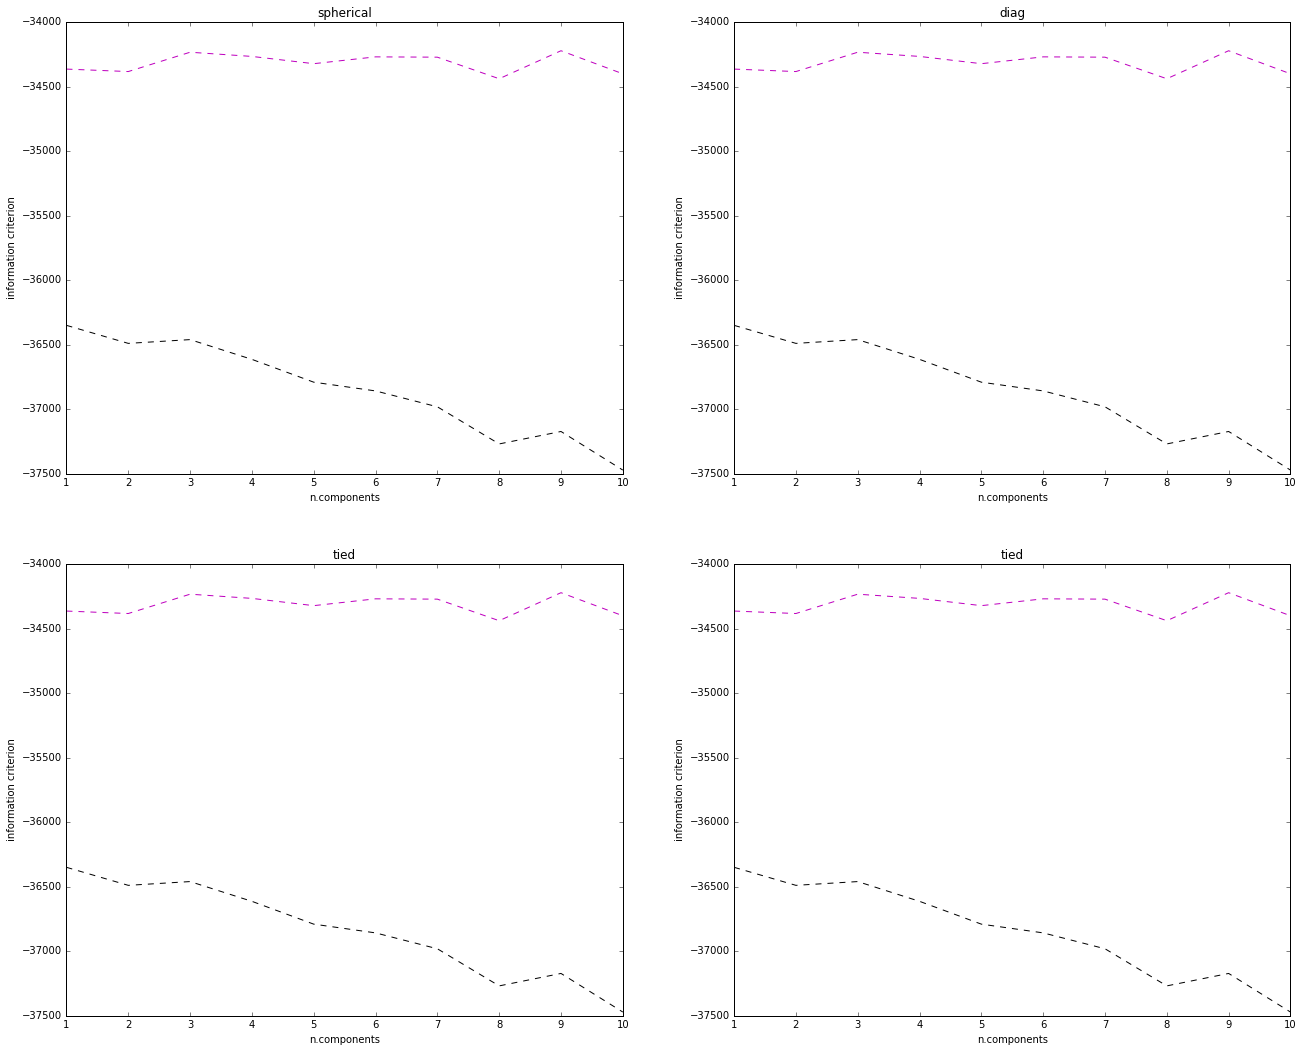

In [13]:

train_target_user, train_feature_user, test_target_user, test_feature_user = pre_process(data_user[0], 5, True);

num_components = 11
covariances=('spherical', 'diag', 'tied', 'full');
models = np.array([dict((covar_type, GMM(n_components=i, covariance_type=covar_type)) 
                   for covar_type in covariances) for i in np.arange(1, num_components)]);

AIC = [[0]*(num_components-1)]*4
BIC = [[0]*(num_components-1)]*4

plt.figure(figsize=(20,20));
plt.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.2);

for n_components in range(10):
    for index, (name, model) in enumerate(models[n_components].items()):
#         print (name, model);
#         model.means_ = np.array([train_feature_user.mean(axis=0)]*(n_components+1));
        model.fit(train_feature_user);
        AIC[index][n_components] = model.aic(train_feature_user);
        BIC[index][n_components] = model.bic(train_feature_user);

print AIC;
print BIC;

plt.subplot(221);
plt.plot(np.arange(1,num_components), AIC[0], '--k', label = "AIC");
plt.plot(np.arange(1,num_components), BIC[0], '--m', label = "BIC");
plt.xlabel("n.components");
plt.ylabel("information criterion");
plt.title("spherical");

plt.subplot(222);
plt.plot(np.arange(1,num_components), AIC[1], '--k', label = "AIC");
plt.plot(np.arange(1,num_components), BIC[1], '--m', label = "BIC");
plt.xlabel("n.components");
plt.ylabel("information criterion");
plt.title("diag");

plt.subplot(223);
plt.plot(np.arange(1,num_components), AIC[2], '--k', label = "AIC");
plt.plot(np.arange(1,num_components), BIC[2], '--m', label = "BIC");
plt.xlabel("n.components");
plt.ylabel("information criterion");
plt.title("tied");

plt.subplot(224);
plt.plot(np.arange(1,num_components), AIC[3], '--k', label = "AIC");
plt.plot(np.arange(1,num_components), BIC[3], '--m', label = "BIC");
plt.xlabel("n.components");
plt.ylabel("information criterion");
plt.title("tied");


In [ ]:

import random

imposter_index = [random.randrange(400, len(train_feature), 13) for i in range(100)];
imposter_target = np.array([train_target[i] for i in imposter_index]); 
imposter_feature = np.array([train_feature[i] for i in imposter_index]);
print imposter_target;

feature_user = np.concatenate((train_feature_user, test_feature_user), axis=0);
genuine_index = [random.randrange(0, len(feature_user), 3) for i in range(100)];
genuine_user = np.array([feature_user[i] for i in genuine_index]);
print feature_user;

profiles = dict((covar_type, GMM(n_components=10, covariance_type=covar_type, init_params='wc', n_iter=20)) 
                   for covar_type in covariances);

model = profiles["diag"]
loo = cross_validation.LeaveOneOut(len(feature_user));
Scores = [];

for train_index, test_index in loo:
#     print("TRAIN: ", train_index, "TEST: ", test_index);
    train, test = feature_user[train_index], feature_user[test_index];
    model.fit(train);
    Scores.append(model.score(test));
    
Scores = np.array(Scores).ravel();
mean = np.mean(Scores);
std = np.std(Scores);
k = 0.4;
dis = [Scores[i] for i in range(len(Scores)) if abs(Scores[i]-mean) < k*std]; 
threshold_user = min(dis);

#print "Scores: ", Scores;
print "mean: ", mean, "std: ", std;
print threshold_user;

reject, accept = 0, 0;
model.fit(feature_user);
for i in range(len(imposter_feature)):
    score = model.score(imposter_feature[i]);
    distance = abs(score-mean);
#     print "score: ", score;
    if(score < threshold_user):
        reject = reject+1;
    else:
        accept = accept+1

FAR = accept;

reject, accept = 0, 0;
for i in range(len(genuine_user)):
    score = model.score(genuine_user[i]);
    distance = abs(score-mean);
#     print "score: ", score;
    if(score < threshold_user):
        reject = reject + 1;
    else:
        accept = accept + 1;

FRR = reject;
print "FAR: ", FAR
print "FRR:", FRR;
# for index, (name, model) in enumerate(profiles.items()):
    
# #     model.means_ = np.array([train_feature_user.mean(axis=0)]); ## surprivised method
#     model.fit(train_feature_user[0:100]);
    
#     # I want to get the probability of every user who belong to this cluster under the current model
#     score_genuine = model.score(test_feature_user);
#     score_imposter = model.score(imposter_feature);    
    
#     proba_genuine = model.predict_proba(test_feature_user);
#     max_proba_genuine = [0]*len(proba_genuine);
#     proba_imposter = model.predict_proba(imposter_feature);
#     max_proba_imposter = [0]*len(proba_imposter);
    
#     for i in range(len(proba_genuine)):
#         max_proba_genuine[i] = proba_genuine[i].max();
        
#     for i in range(len(proba_imposter)):
#         max_proba_imposter[i] = proba_imposter[i].max();
    
#     print "Genuine: ", score_genuine, max_proba_genuine;
#     print "Imposter: ", score_imposter, max_proba_imposter;
#     print "Mean value (Genuine): ", score_genuine.mean();
#     print "Mean value (Imposter): ", score_imposter.mean();
    

In [ ]:
# plt.figure(figsize=(3 * 4 / 2, 6));

plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05, left=.01, right=.99);

plt.subplot(121);
plt.plot([1,2,3,4,5], [1,4,9,16,25], [9,10,11,12,13], 'x');
# plt.plot([1, 2, 3], 'x', color = 'red');
plt.xticks(range(12), rotation=17);
# plt.xticks(range(5), ('Tom', 'Dick', 'Harry', 'Sally', 'Sue'));
plt.subplot(122);
# plt.scatter([1,2], 'o');

In [ ]:
from sklearn.mixture import GMM

gmm = GMM(n_components=n_classes, covariance_type='spherical', init_params='wc', n_iter=20);
gmm.means_ = np.array([train_data[train_target == user].mean(axis=0) for user in subjects]);
gmm.fit(train_data);


In [ ]:
print gmm.predict(test_data[3000:3020]);
print test_target[3000:3020];